#### authors: Rafael Dousse, Eva Ray, Massimo Stefani

# PW4 - Linear Regression

## Imports

In [702]:
import random
import pandas as pd
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt

## Load data

Define the path to the file containing the data

In [703]:
datafile = "lausanne-appart.csv"

Read the data

In [704]:
dataset = pd.read_csv(datafile)

Display first rows

In [705]:
dataset.head()

,living_area,nb_rooms,rent_price
0,69,3.0,1810
1,95,3.5,2945
2,21,1.5,685
3,20,1.0,720
4,33,1.5,830


## Exercise 1 - Visualize the data

a) Plot a histogram to visualize the distribution of the renting price

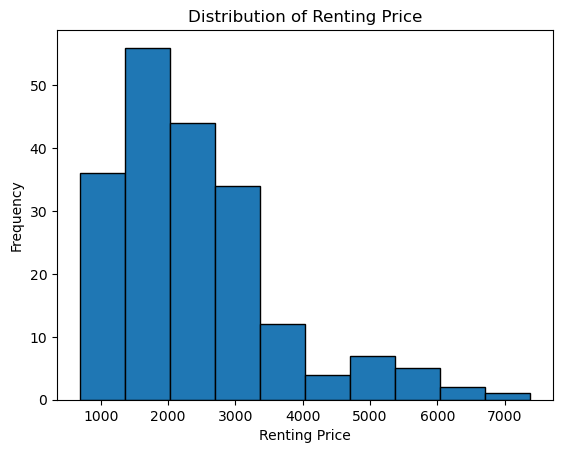

In [706]:
# Your code here
plt.hist(dataset['rent_price'], edgecolor='black')
plt.title('Distribution of Renting Price')
plt.xlabel('Renting Price')
plt.ylabel('Frequency')
plt.show()

b) Plot a histogram to visualize the distribution of the living area

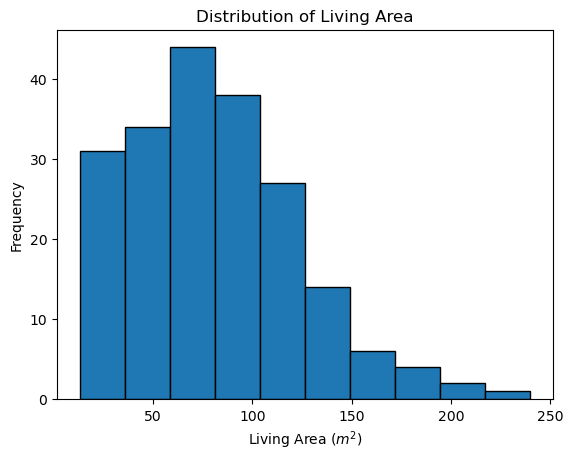

In [707]:
# Your code here
plt.hist(dataset['living_area'], edgecolor='black')
plt.title('Distribution of Living Area')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Frequency')
plt.show()

c) Plot a scatter plot of renting price as a function of living area

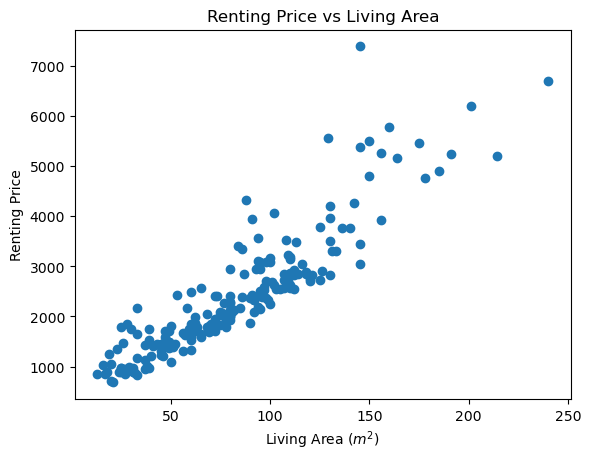

In [708]:
# Your code here
plt.scatter(dataset['living_area'], dataset['rent_price'])
plt.title('Renting Price vs Living Area')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Renting Price')
plt.show()

## Exercise 2 - Normal equations for linear regression

a) Implement the closed form solution to this problem using the following normal equation:

<div><div style="display: table-cell; width: 100%;"><center>$\theta = (X^{T}X)^{-1}X^{T}\vec{y}$</center></div><div style="display: table-cell; width: 100%;">$(3)$</div></div>

Assuming $x$ is the living area and $y$ is the renting price. Use `numpy` for the vector operations. Plot the computed line on top of the scatter plot of exercise 1.

In [709]:
# Your code here

b) Compute the overall cost value according to the following equation:

<div><div style="display: table-cell; width: 100%;"><center>$J(\theta) = \frac{1}{2N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n})^{2}$</center></div><div style="display: table-cell; width: 100%;">$(2)$</div></div>

In [710]:
# Your code here

## Exercise 3 - Gradient descent for linear regression

Implement the _full batch_ gradient descent algorithm for the previous problem. As seen in the
theory, the update rules are:

<div><div style="display: table-cell; width: 100%;"><center>$\theta_{0} \leftarrow \theta_{0} - \alpha \frac{1}{N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n})$</center></div><div style="display: table-cell; width: 100%;">$(6)$</div></div>

<div><div style="display: table-cell; width: 100%;"><center>$\theta_{1} \leftarrow \theta_{1} - \alpha \frac{1}{N} \sum_{n=1}^{N} (h_{\theta}(\mathbf{x}_{n}) - y_{n}) x_{n,1}$</center></div><div style="display: table-cell; width: 100%;">$(7)$</div></div>

**Remark** You need to iterate several times over the training set. If you have problems of convergence, you need to use a smaller value of $\alpha$. Values such as $0.000001$ are common.

In [711]:
# Your code here

a) Plot the cost value (Equation 2) as a function of the iterations. What do you observe?

In [712]:
# Your code here

_Your answer here_

b) Imagine a stopping criterion, i.e. when do we stop iterating on the training set?

_Your answer here_

c) Plot the computed line $h_{\theta}(\mathbf{x})$ on top of the scatter plot of exercise 1.

In [713]:
# Your code here

d) Compute the final cost value according to Equation 2 and compare it to the one of exercise 2. What can you conclude?

In [714]:
# Your code here

_Your answer here_

## Exercise 4 - Stochastic gradient descent for linear regression

Implement the stochastic gradient descent algorithm for the previous problem. As seen in the theory, the update rules are:

<div><div style="display: table-cell; width: 100%;"><center>$\theta_{i} \leftarrow \theta_{i} - \alpha (h_{\theta}(\mathbf{x}_{n}) - y_{n}) x_{n,i}$</center></div><div style="display: table-cell; width: 100%;">$(8)$</div></div>

In [715]:
# Your code here
X = dataset['living_area'].to_numpy()
# add bias term
X_b = np.c_[np.ones((X.shape[0], 1)), X]

y = dataset['rent_price'].to_numpy()

# random initialization of theta
theta = np.zeros(2)

# parameters
alpha = 0.00001
n_epochs = 2
m = len(y)
cost_history = []
thetas = []
y_pred_all = np.dot(X_b, theta)

for epoch in range(n_epochs):
    indices = np.random.permutation(m)
    for i in indices:
        xi = X_b[i]
        yi = y[i]

        # Update theta
        gradient = (np.dot(xi, theta) - yi) * xi
        theta = theta - alpha * gradient

        y_pred_all = np.dot(X_b, theta)
        cost = (1 / (2 * m)) * np.sum((y_pred_all - y) ** 2)
        cost_history.append(cost)
        thetas.append(theta.copy())

print("Final theta:", theta)
print("Final cost:", cost_history[-1])


Final theta: [ 0.4823133  31.27166274]
Final cost: 172849.6826694811


a) Plot the computed line $h_{\theta}(\mathbf{x})$ on top of the scatter plot of exercise 1.

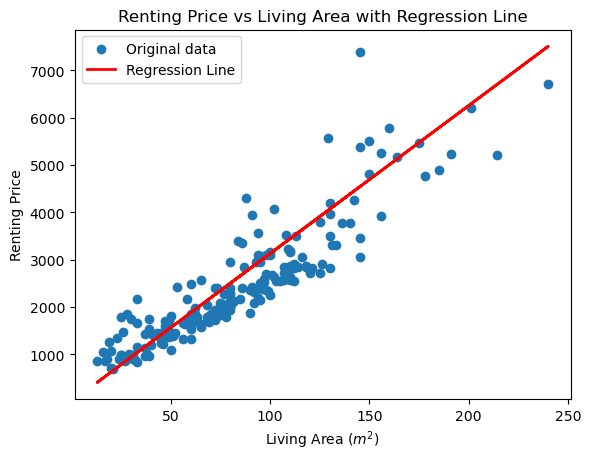

In [716]:
# Your code here
plt.scatter(dataset['living_area'], dataset['rent_price'], label='Original data')
plt.plot(X, y_pred_all, color='red', linewidth=2, label='Regression Line')
plt.title('Renting Price vs Living Area with Regression Line')
plt.xlabel('Living Area ($m^2$)')
plt.ylabel('Renting Price')
plt.legend()
plt.show()

b) How many samples do you need to visit for reaching the convergence?

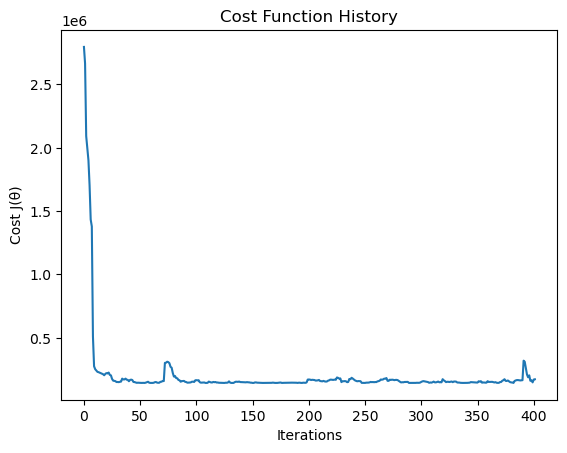

In [717]:
plt.plot(cost_history)  # Plot every 10th point for clarity
plt.title('Cost Function History')
plt.xlabel('Iterations')
plt.ylabel('Cost J(θ)')
plt.show()

We start seeing convergence after around 30 samples. However, we can see that the cost function is still oscillating a little bit, which is typical for stochastic gradient descent.

c) What kind of stopping criterion could we use here?

We could use one of the following stopping criteria:
1. Set a maximum number of iterations.
2. Stop when the change in cost function between iterations is below a certain threshold.

d) Compute the final cost value according to Equation 2 and compare it to the one of exercise 2 and 3. What can you conclude?

In [718]:
# Your code here
final_cost_sgd = cost_history[-1]
print("Final cost from SGD:", final_cost_sgd)

Final cost from SGD: 172849.6826694811


_Your answer here_

## Exercise 5 - Review questions

a) The linear regression has a mathematical _closed form_ solution. Then, in which conditions would we prefer a gradient descent algorithm to compute the regression model?

The closed form solution is not ideal for very large datasets or when the feature set is very large (high dimensionality). Indeed, this method requires the computation of the inverse of the matrix \(X^TX\), which can be computationally expensive and numerically unstable for large matrices. In such cases, gradient descent methods (like batch or stochastic gradient descent) are preferred as they can handle larger datasets more efficiently.

b) Outliers in a data set can be defined as values that are out of the "usual" range in comparison with other values. They typically come from noise or anomalies in the data capturing process. What is the impact of an outlier in the stochastic gradient descent process? What if we have many outliers? _Hint_: look at the equation of the MSE, and to the equation of the update rule.

Outliers can significantly impact the stochastic gradient descent process. Since the update rule in SGD is based on the error between the predicted and actual values, an outlier can cause a large error, leading to a disproportionately large update to the model parameters. This is even more emphasized in the Mean Squared Error (MSE) cost function, where the error is squared, amplifying the effect of outliers. If there are many outliers in the dataset, they can skew the model's learning process, leading to poor generalization on the overall data.

c) In the case of stochastic gradient descent, what is the danger of having a too large or too small $\alpha$ value? Could you think of a better (more advanced) strategy as the one stated in Slide 36?

- **Too large α**: If the learning rate α is too large, we may oscillate around the minimum or even diverge from it (we can bounce around the minimum). This can lead to an unstable training process where the cost function does not decrease and may even increase over iterations.
- **Too small α**: Conversely, if α is too small, the updates will be very small, leading to a slow convergence. This can result in a long training time and may cause the algorithm to get stuck in a local minimum.
- **Better Strategy**: A more advanced strategy could be to inspect the evolution of the cost function over iterations and adaptively adjust α based on the observed behavior. For instance, if the cost function is decreasing steadily, we could slightly increase α to speed up convergence. If we observe oscillations or increases in the cost function, we could decrease α to stabilize the training process. This adaptive learning rate approach can help balance convergence speed and stability.

d) Let's assume we expect that the target variable $y$ has a dependency to the square and to the cube of one of the feature $x_d$ in our multi-variable training set $(x_1, \ldots, x_d, \ldots, x_D)$. How would you proceed? Do we need to take precautions in terms of numerical stability?

To account for the dependency of the target variable `y` on the square and cube of a feature `x_d`, we can create new features in our dataset that represent these polynomial terms. Specifically, we can add two new features: `x_d^2` and `x_d^3`. This way, our model can learn the relationship between `y` and these polynomial terms.

Yes, we need to take precautions in terms of numerical stability. Squared or cubed features can lead to very large values, especially for higher degrees, which can cause numerical instability during the training process. To mitigate this, we can:
1. Normalize or standardize the features before adding polynomial terms.
2. Use regularization techniques to prevent overfitting on the squared and cubed terms.

e) _Advanced_. Could we use a descent algorithm without computing the gradient? If yes, give a pseudo code of the algorithm to find $(\theta_{0}, \theta_{1})$ using a linear regression $h_{\theta}(x) = \theta_0 + \theta_1 x$.

It seems possible to use a descent algorithm that do not require the explicit computation of gradients. We could follow these steps:
1. Initialize theta randomly.
2. Change theta slightly in a random direction.
3. Compute the cost function.
4. If the cost decreases, keep the change. Otherwise, revert it.
5. Repeat until the stopping criterion is met.

## Exercise 7 - Multi variable linear regression

### a

Implement one of the gradient descent algorithm (ex. 3-5) for the multi-variable linear regression assuming x1 being the living area and x2 the square of the living area. Plot the computed curve (second order) on top of the scatter plot of exercise 1. Do you observe a reduction in the loss ?

In [719]:
def normalize(x):
    return (x - np.mean(x)) / np.std(x), np.mean(x), np.std(x)

def compute_cost(X, y, theta):
    y_pred = X.dot(theta)
    return (1 / (2 * len(y))) * np.sum((y_pred - y) ** 2)

def gradient_descent(X, y, alpha=0.01, num_iters=1000):
    theta = np.zeros((X.shape[1], 1))
    cost_history = []
    for i in range(num_iters):
        y_pred = X.dot(theta)
        gradient = (1 / len(y)) * X.T.dot(y_pred - y)
        theta = theta - alpha * gradient
        cost = compute_cost(X, y, theta)
        cost_history.append(cost)
    return theta, cost_history


In [720]:
x1_a = dataset['living_area'].to_numpy()
x2_a = x1_a ** 2

y = dataset['rent_price'].to_numpy().reshape(-1, 1)

N = len(y)

# Normalize features
x1_norm, m1, s1 = normalize(x1_a)
x2_norm, m2, s2 = normalize(x2_a)

# Matrix with bias term
X_a = np.c_[np.ones(N), x1_norm, x2_norm]

In [721]:
alpha = 0.01
num_iters = 2000
theta_a, cost_a = gradient_descent(X_a, y, alpha, num_iters)

print("Final theta :", theta_a.ravel())
print("Final cost :", cost_a[-1])

Final theta : [2378.24377666  718.2152659   408.77750835]
Final cost : 134196.96969168508


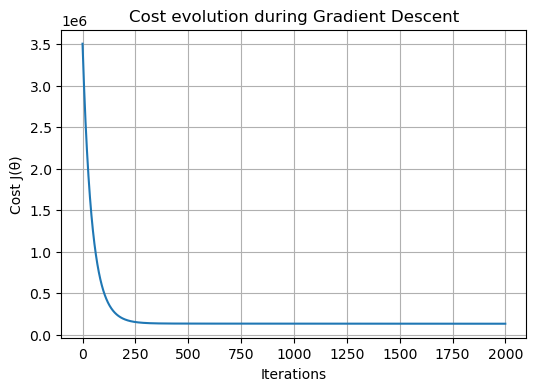

In [722]:
plt.figure(figsize=(6,4))
plt.plot(cost_a)
plt.xlabel("Iterations")
plt.ylabel("Cost J(θ)")
plt.title("Cost evolution during Gradient Descent")
plt.grid(True)
plt.show()

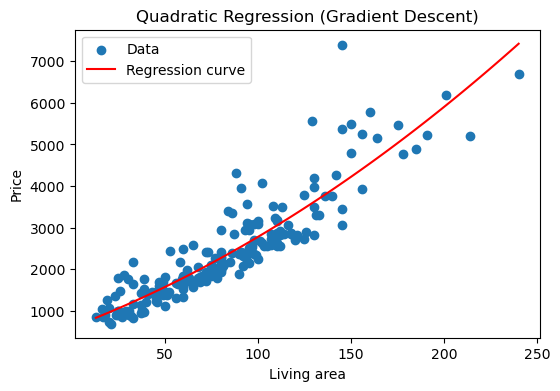

In [723]:
plt.figure(figsize=(6,4))
plt.scatter(x1_a, y, label="Data")
x_sorted = np.linspace(min(x1_a), max(x1_a), 100)
x1_s = (x_sorted - m1) / s1
x2_s = ((x_sorted ** 2) - m2) / s2
X_plot = np.c_[np.ones(len(x_sorted)), x1_s, x2_s]
y_pred = X_plot.dot(theta_a)
plt.plot(x_sorted, y_pred, color='red', label="Regression curve")
plt.xlabel("Living area")
plt.ylabel("Price")
plt.legend()
plt.title("Quadratic Regression (Gradient Descent)")
plt.show()

### b

Implement one of the gradient descent algorithm (ex. 3-5) for the multi-variable linear regression assuming x1 being the living area and x2 the number of bedrooms. Do you observe a reduction in the loss ?

In [724]:
x1_b = dataset['living_area'].to_numpy()
x2_b = dataset['nb_rooms'].to_numpy()

# Normalize features
x1_norm_b, m1b, s1b = normalize(x1_b)
x2_norm_b, m2b, s2b = normalize(x2_b)

# Matrix with bias term
X_b = np.c_[np.ones(N), x1_norm_b, x2_norm_b]

In [725]:
theta_b, cost_b = gradient_descent(X_b, y, alpha, num_iters)

print("Final theta :", theta_b.ravel())
print("Final cost :", cost_b[-1])

Final theta : [2378.24377666 1112.31660277   -9.97084372]
Final cost : 137891.84029018503


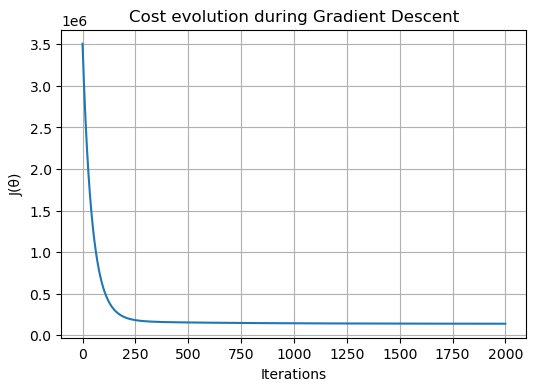

In [726]:
plt.figure(figsize=(6,4))
plt.plot(cost_b)
plt.xlabel("Iterations")
plt.ylabel("J(θ)")
plt.title("Cost evolution during Gradient Descent")
plt.grid(True)
plt.show()

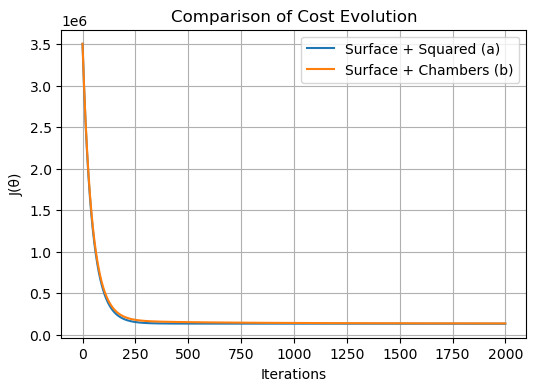

Final cost (a): 134196.9697
Final cost (b): 137891.8403


In [727]:
plt.figure(figsize=(6,4))
plt.plot(cost_a, label="Surface + Squared (a)")
plt.plot(cost_b, label="Surface + Chambers (b)")
plt.title("Comparison of Cost Evolution")
plt.xlabel("Iterations")
plt.ylabel("J(θ)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Final cost (a): {cost_a[-1]:.4f}")
print(f"Final cost (b): {cost_b[-1]:.4f}")